In [7]:
%%time
import numpy as np
import pandas as pd
import torch
import shap
from hydra import initialize, compose
from lstm_model import RegressionLSTM
from pickle import load
from transformer.transformer_model import CMIPTimeSeriesDataset

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")

model = RegressionLSTM(num_sensors=len(cfg.model.input), hidden_units=cfg.model.hidden_units,cfg=cfg)
model_name = cfg.run_name
checkpoint = torch.load(f'{cfg.project}/checkpoint/lstm_checkpoint_{model_name}.pt')
#if distributed training, remove module. from keys
for key in list(checkpoint['model_state_dict'].keys()):
    checkpoint['model_state_dict'][key.replace('module.', '')] = checkpoint['model_state_dict'].pop(key)
model.load_state_dict(checkpoint['model_state_dict'])
final_input = pd.read_csv(f'{cfg.data}/observed_timeseries30_data.csv')

scaler = load(open(f'{cfg.project}/checkpoint/lstm_scaler_{cfg.run_name}.pkl', 'rb'))
final_input.loc[:,tuple(cfg.model.input)] = scaler.transform(final_input[cfg.model.input])
final_input= final_input[cfg.model.input + cfg.model.id]
ds = CMIPTimeSeriesDataset(final_input,cfg.model.seq_len,len(cfg.model.input) + len(cfg.model.id),cfg)
final_input = torch.tensor(ds.data[:,:,:6]).float()


CPU times: user 699 ms, sys: 94.5 ms, total: 794 ms
Wall time: 412 ms


Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


tensor([[ 9.7207e+04,  2.8156e+02,  5.1975e+01,  ...,  1.9840e+03,
          4.3822e+01, -8.0000e+01],
        [ 9.7125e+04,  2.8152e+02,  5.2061e+01,  ...,  1.9850e+03,
          4.3822e+01, -8.0000e+01],
        [ 9.7197e+04,  2.8165e+02,  5.3105e+01,  ...,  1.9860e+03,
          4.3822e+01, -8.0000e+01],
        ...,
        [ 1.0008e+05,  2.7474e+02,  2.4532e+01,  ...,  2.0170e+03,
          6.8325e+01, -1.2875e+02],
        [ 1.0023e+05,  2.7340e+02,  2.5560e+01,  ...,  2.0180e+03,
          6.8325e+01, -1.2875e+02],
        [ 1.0025e+05,  2.7369e+02,  2.6312e+01,  ...,  2.0190e+03,
          6.8325e+01, -1.2875e+02]])

In [8]:
e = shap.KernelExplainer(
        model, 
        final_input)


#         %%time
# x_samples = x_train[np.random.choice(np.arange(len(x_train)), 300, replace=False)]
# print(len(x_samples))
# shap_values = e.shap_values(
#     torch.from_numpy(x_samples).to(DEVICE)
# )


In [11]:
len(final_input)

3311

In [50]:
x_samples = final_input[np.random.choice(np.arange(len(final_input)), 10, replace=False)]
print(len(x_samples))
print(x_samples.shape)
shap_values = e.shap_values(
    x_samples
)

10
torch.Size([10, 30, 6])


Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [39]:
import pandas as pd
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.mean(np.abs(shap_values), axis=0),axis=1)[0], 
    "stdev_abs_shap": np.std(np.abs(np.abs(shap_values)[0]),axis=1)[0],
})
df.sort_values("mean_abs_shap", ascending=False)[:10]

,mean_abs_shap,stdev_abs_shap
1,0.040724,0.001089
4,0.032072,0.001155
5,0.022579,0.000587
0,0.017334,0.000589
3,0.007983,0.000701
2,0.007928,0.000636


In [60]:
x_reshaped = x_samples.reshape(-1,6)

In [61]:
shap_reshaped = shap_values[0].reshape(-1,6)

In [63]:
shap_reshaped.shape

(300, 6)

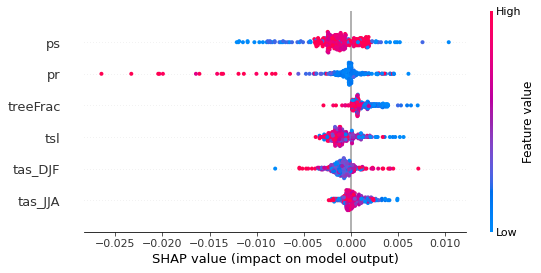

In [64]:
shap.summary_plot(shap_reshaped, features=x_reshaped, feature_names=['ps','tsl','treeFrac','pr','tas_DJF','tas_JJA'])
